In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [346]:
cci = pd.read_csv("../raw/CCI Price Index.csv", header=None)
cci = cci[cci.columns[[0,1,5,9,13]]].reset_index(drop=True)
cci = pd.concat([cci.iloc[[1, 3]], cci.iloc[8:2919]]).reset_index(drop=True)

h1 = cci.iloc[0].fillna('').astype(str).str.strip()
h2 = cci.iloc[1].fillna('').astype(str).str.strip()
new_cols = (h1 + ' ' + h2).str.replace(r'\s+', ' ', regex=True).tolist()
cci = cci.iloc[2:].copy()
cci.columns = new_cols
date_col = new_cols[0]
cci[date_col] = pd.to_datetime(cci[date_col])
cci = cci.set_index(date_col)
cci.index.name = 'Date'

cci.index = pd.to_datetime(cci.index)
cci = cci[cci.columns].apply(pd.to_numeric, errors='coerce')

In [347]:
print(cci.head(5))

            CCI 5500 FOB with VAT  CCI 5000 FOB with VAT  CCI 3800 Import CFR  \
Date                                                                            
2025-07-04                  621.0                  553.0               395.12   
2025-07-03                  620.0                  552.0               395.12   
2025-07-02                  620.0                  552.0               395.67   
2025-07-01                  620.0                  551.0               393.50   
2025-06-30                  620.0                  550.0               393.50   

            CCI 4700 Import CFR  
Date                             
2025-07-04               511.14  
2025-07-03               511.14  
2025-07-02               511.86  
2025-07-01               509.52  
2025-06-30               509.52  


In [348]:
stocks = pd.read_csv("../raw/Thermal Coal Stocks.csv", header=None)
stocks = stocks[stocks.columns[[0,2]]].reset_index(drop=True)
stocks = pd.concat([stocks.iloc[[1, 3]], stocks.iloc[6:2919]]).reset_index(drop=True)

h1 = stocks.iloc[0].fillna('').astype(str).str.strip()
h2 = stocks.iloc[1].fillna('').astype(str).str.strip()
new_cols = (h1 + ' ' + h2).str.replace(r'\s+', ' ', regex=True).tolist()

stocks = stocks.iloc[2:].copy()
stocks.columns = new_cols

date_col = new_cols[0]
stocks[date_col] = pd.to_datetime(stocks[date_col])
stocks = stocks.set_index(date_col)
stocks.index.name = 'Date'

stocks.index = pd.to_datetime(stocks.index)
stocks = stocks[stocks.columns].apply(pd.to_numeric, errors='coerce')

In [349]:
print(stocks.head(5))

            Six Coastal Power Groups Days of Burn
Date                                             
2025-07-04                                   16.8
2025-07-03                                   16.9
2025-07-02                                   16.9
2025-07-01                                   16.8
2025-06-30                                   16.8


In [350]:
df = cci.join(stocks, how='inner')
df.sort_index(ascending=True, inplace=True)
print(df.head(5))

            CCI 5500 FOB with VAT  CCI 5000 FOB with VAT  CCI 3800 Import CFR  \
Date                                                                            
2016-10-08                  585.0                  531.0               334.23   
2016-10-09                  590.0                  536.0               333.73   
2016-10-10                  592.0                  537.0               341.51   
2016-10-11                  599.0                  540.0               348.30   
2016-10-12                  602.0                  544.0               351.18   

            CCI 4700 Import CFR  Six Coastal Power Groups Days of Burn  
Date                                                                    
2016-10-08               465.72                                   23.4  
2016-10-09               465.03                                   22.4  
2016-10-10               474.97                                   23.5  
2016-10-11               479.61                                   2

In [351]:
cci5500 = df[['Six Coastal Power Groups Days of Burn','CCI 5500 FOB with VAT']]
cci5500.fillna(method='ffill', inplace=True)
print(cci5500.head())
rows, cols = cci5500.shape
print(f"Shape: {rows} rows × {cols} columns")

            Six Coastal Power Groups Days of Burn  CCI 5500 FOB with VAT
Date                                                                    
2016-10-08                                   23.4                  585.0
2016-10-09                                   22.4                  590.0
2016-10-10                                   23.5                  592.0
2016-10-11                                   24.7                  599.0
2016-10-12                                   23.5                  602.0
Shape: 1967 rows × 2 columns


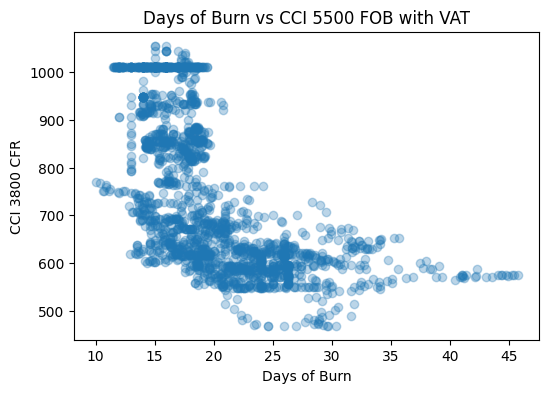

r: -0.6306809885899554


In [352]:
x = cci5500['Six Coastal Power Groups Days of Burn']
y = cci5500['CCI 5500 FOB with VAT']

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.3)
plt.xlabel('Days of Burn')
plt.ylabel('CCI 3800 CFR')
plt.title('Days of Burn vs CCI 5500 FOB with VAT')
plt.show()

print("r:", np.corrcoef(x, y)[0,1])

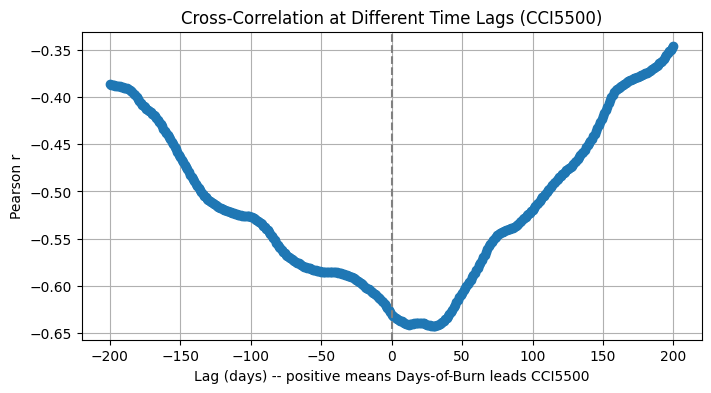

Strongest |r| at lag = 30 days → r = -0.643


In [353]:
series = df[['Six Coastal Power Groups Days of Burn','CCI 5500 FOB with VAT']].fillna(method='ffill')
x = series.iloc[:,0]
y = series.iloc[:,1]

max_lag = 200
lags = range(-max_lag, max_lag+1)

corrs = []
for lag in lags:
    # positive lag: x leads y (x(t) vs y(t+lag))
    # negative lag: y leads x (x(t) vs y(t+lag) with lag<0)
    corr = x.corr(y.shift(-lag))
    corrs.append(corr)

corr_series = pd.Series(corrs, index=lags)

plt.figure(figsize=(8,4))
corr_series.plot(marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Lag (days) -- positive means Days-of-Burn leads CCI5500')
plt.ylabel('Pearson r')
plt.title('Cross-Correlation at Different Time Lags (CCI5500)')
plt.grid(True)
plt.show()

best_lag  = corr_series.abs().idxmax()
best_corr = corr_series.loc[best_lag]
print(f"Strongest |r| at lag = {best_lag} days → r = {best_corr:.3f}")

In [354]:
cci5000 = df[['Six Coastal Power Groups Days of Burn','CCI 5000 FOB with VAT']]
cci5000.fillna(method='ffill', inplace=True)
print(cci5000.head())
rows, cols = cci5000.shape
print(f"Shape: {rows} rows × {cols} columns")

            Six Coastal Power Groups Days of Burn  CCI 5000 FOB with VAT
Date                                                                    
2016-10-08                                   23.4                  531.0
2016-10-09                                   22.4                  536.0
2016-10-10                                   23.5                  537.0
2016-10-11                                   24.7                  540.0
2016-10-12                                   23.5                  544.0
Shape: 1967 rows × 2 columns


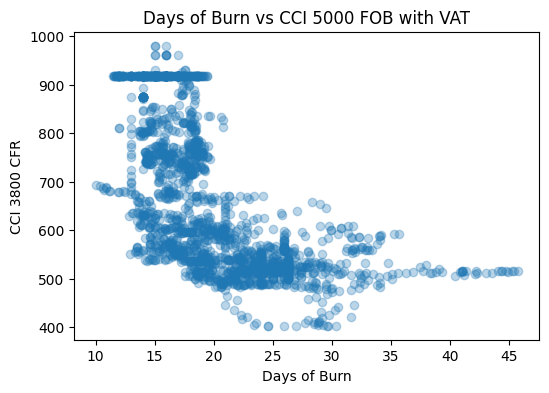

r: -0.6204741218003215


In [355]:
x = cci5000['Six Coastal Power Groups Days of Burn']
y = cci5000['CCI 5000 FOB with VAT']

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.3)
plt.xlabel('Days of Burn')
plt.ylabel('CCI 3800 CFR')
plt.title('Days of Burn vs CCI 5000 FOB with VAT')
plt.show()

print("r:", np.corrcoef(x, y)[0,1])

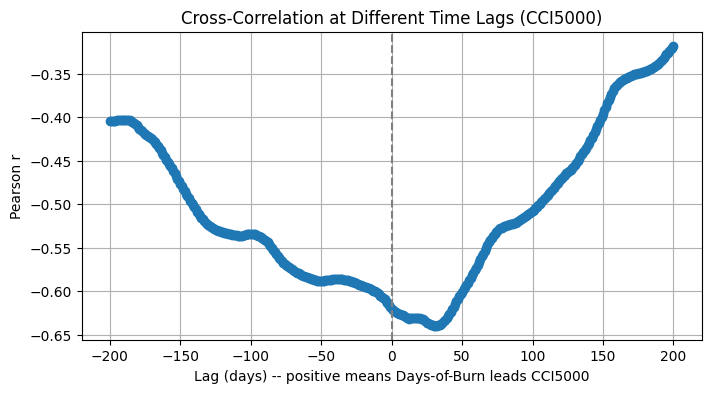

Strongest |r| at lag = 31 days → r = -0.640


In [356]:
series = df[['Six Coastal Power Groups Days of Burn','CCI 5000 FOB with VAT']].fillna(method='ffill')
x = series.iloc[:,0]
y = series.iloc[:,1]

max_lag = 200
lags = range(-max_lag, max_lag+1)

corrs = []
for lag in lags:
    # positive lag: x leads y (x(t) vs y(t+lag))
    # negative lag: y leads x (x(t) vs y(t+lag) with lag<0)
    corr = x.corr(y.shift(-lag))
    corrs.append(corr)

corr_series = pd.Series(corrs, index=lags)

plt.figure(figsize=(8,4))
corr_series.plot(marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Lag (days) -- positive means Days-of-Burn leads CCI5000')
plt.ylabel('Pearson r')
plt.title('Cross-Correlation at Different Time Lags (CCI5000)')
plt.grid(True)
plt.show()

best_lag  = corr_series.abs().idxmax()
best_corr = corr_series.loc[best_lag]
print(f"Strongest |r| at lag = {best_lag} days → r = {best_corr:.3f}")

In [357]:
cci3800 = df[['Six Coastal Power Groups Days of Burn','CCI 3800 Import CFR']]
cci3800.fillna(method='ffill', inplace=True)
print(cci3800.head())
rows, cols = cci3800.shape
print(f"Shape: {rows} rows × {cols} columns")

            Six Coastal Power Groups Days of Burn  CCI 3800 Import CFR
Date                                                                  
2016-10-08                                   23.4               334.23
2016-10-09                                   22.4               333.73
2016-10-10                                   23.5               341.51
2016-10-11                                   24.7               348.30
2016-10-12                                   23.5               351.18
Shape: 1967 rows × 2 columns


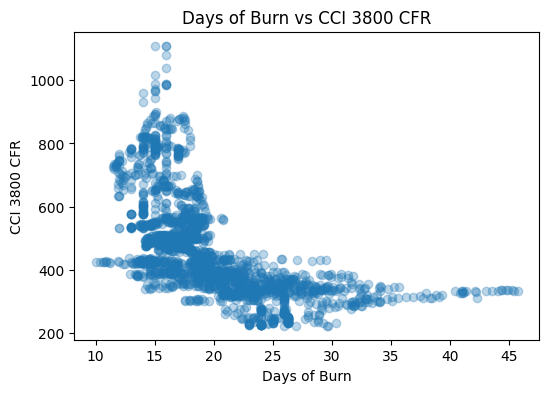

r: -0.6079977697273581


In [358]:
x = cci3800['Six Coastal Power Groups Days of Burn']
y = cci3800['CCI 3800 Import CFR']

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.3)
plt.xlabel('Days of Burn')
plt.ylabel('CCI 3800 CFR')
plt.title('Days of Burn vs CCI 3800 CFR')
plt.show()

print("r:", np.corrcoef(x, y)[0,1])

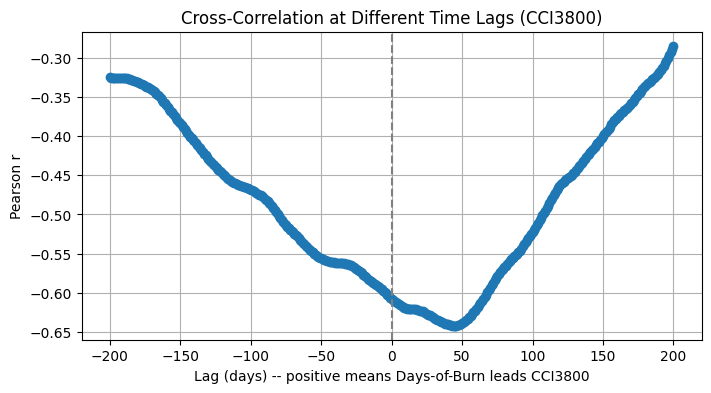

Strongest |r| at lag = 45 days → r = -0.642


In [359]:
series = df[['Six Coastal Power Groups Days of Burn','CCI 3800 Import CFR']].fillna(method='ffill')
x = series.iloc[:,0]
y = series.iloc[:,1]

max_lag = 200
lags = range(-max_lag, max_lag+1)

corrs = []
for lag in lags:
    # positive lag: x leads y (x(t) vs y(t+lag))
    # negative lag: y leads x (x(t) vs y(t+lag) with lag<0)
    corr = x.corr(y.shift(-lag))
    corrs.append(corr)

corr_series = pd.Series(corrs, index=lags)

plt.figure(figsize=(8,4))
corr_series.plot(marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Lag (days) -- positive means Days-of-Burn leads CCI3800')
plt.ylabel('Pearson r')
plt.title('Cross-Correlation at Different Time Lags (CCI3800)')
plt.grid(True)
plt.show()

best_lag  = corr_series.abs().idxmax()
best_corr = corr_series.loc[best_lag]
print(f"Strongest |r| at lag = {best_lag} days → r = {best_corr:.3f}")

In [360]:
cci4700 = df[['Six Coastal Power Groups Days of Burn','CCI 4700 Import CFR']]
cci4700.fillna(method='ffill', inplace=True)
print(cci4700.head())
rows, cols = cci4700.shape
print(f"Shape: {rows} rows × {cols} columns")

            Six Coastal Power Groups Days of Burn  CCI 4700 Import CFR
Date                                                                  
2016-10-08                                   23.4               465.72
2016-10-09                                   22.4               465.03
2016-10-10                                   23.5               474.97
2016-10-11                                   24.7               479.61
2016-10-12                                   23.5               488.19
Shape: 1967 rows × 2 columns


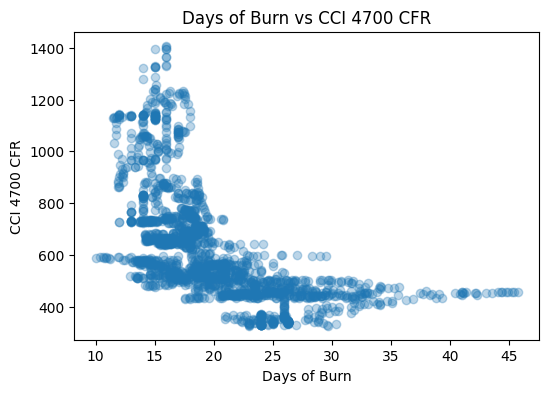

r: -0.6009872083910924


In [361]:
x = cci4700['Six Coastal Power Groups Days of Burn']
y = cci4700['CCI 4700 Import CFR']

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.3)
plt.xlabel('Days of Burn')
plt.ylabel('CCI 4700 CFR')
plt.title('Days of Burn vs CCI 4700 CFR')
plt.show()

print("r:", np.corrcoef(x, y)[0,1])

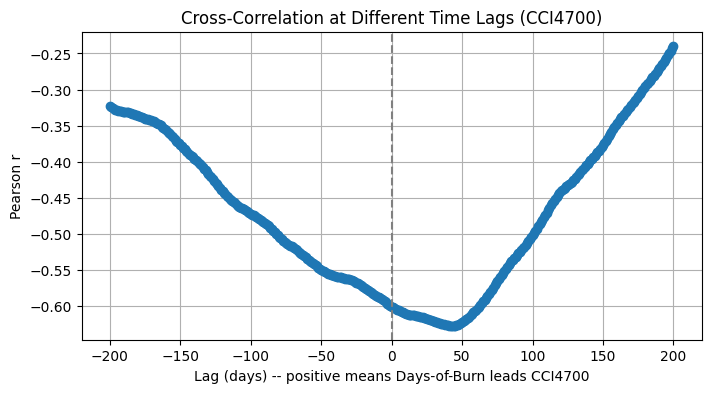

Strongest |r| at lag = 43 days → r = -0.627


In [362]:
series = df[['Six Coastal Power Groups Days of Burn','CCI 4700 Import CFR']].fillna(method='ffill')
x = series.iloc[:,0]
y = series.iloc[:,1]

max_lag = 200
lags = range(-max_lag, max_lag+1)

corrs = []
for lag in lags:
    # positive lag: x leads y (x(t) vs y(t+lag))
    # negative lag: y leads x (x(t) vs y(t+lag) with lag<0)
    corr = x.corr(y.shift(-lag))
    corrs.append(corr)

corr_series = pd.Series(corrs, index=lags)

plt.figure(figsize=(8,4))
corr_series.plot(marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Lag (days) -- positive means Days-of-Burn leads CCI4700')
plt.ylabel('Pearson r')
plt.title('Cross-Correlation at Different Time Lags (CCI4700)')
plt.grid(True)
plt.show()

best_lag  = corr_series.abs().idxmax()
best_corr = corr_series.loc[best_lag]
print(f"Strongest |r| at lag = {best_lag} days → r = {best_corr:.3f}")

In [ ]:
cci4700 = df[['Six Coastal Power Groups Days of Burn','CCI 4700 Import CFR']]
cci4700.fillna(method='ffill', inplace=True)
print(cci4700.head())
rows, cols = cci4700.shape
print(f"Shape: {rows} rows × {cols} columns")

            Six Coastal Power Groups Days of Burn  CCI 4700 Import CFR
Date                                                                  
2016-10-08                                   23.4               465.72
2016-10-09                                   22.4               465.03
2016-10-10                                   23.5               474.97
2016-10-11                                   24.7               479.61
2016-10-12                                   23.5               488.19
Shape: 1967 rows × 2 columns


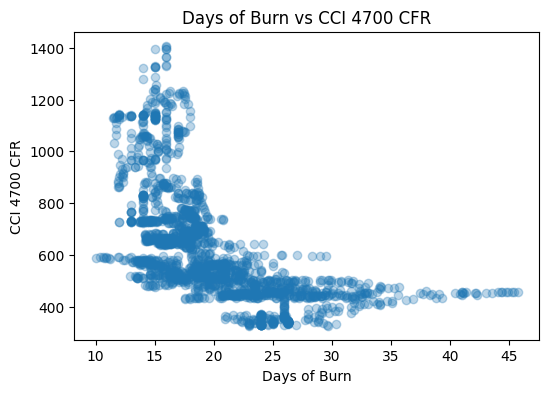

r: -0.6009872083910924


In [ ]:
x = cci4700['Six Coastal Power Groups Days of Burn']
y = cci4700['CCI 4700 Import CFR']

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.3)
plt.xlabel('Days of Burn')
plt.ylabel('CCI 4700 CFR')
plt.title('Days of Burn vs CCI 4700 CFR')
plt.show()

print("r:", np.corrcoef(x, y)[0,1])

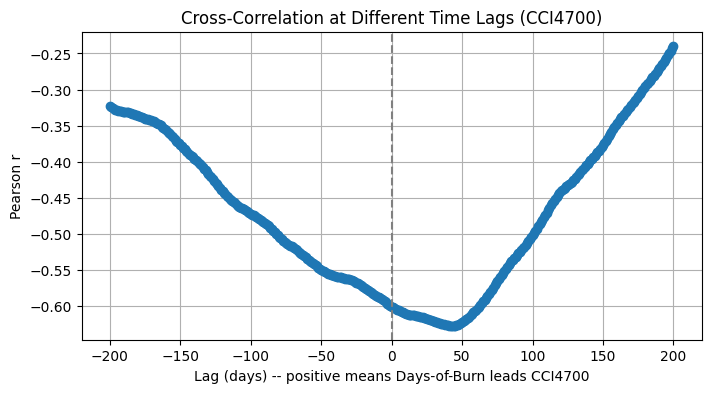

Strongest |r| at lag = 43 days → r = -0.627


In [ ]:
series = df[['Six Coastal Power Groups Days of Burn','CCI 4700 Import CFR']].fillna(method='ffill')
x = series.iloc[:,0]
y = series.iloc[:,1]

max_lag = 200
lags = range(-max_lag, max_lag+1)

corrs = []
for lag in lags:
    # positive lag: x leads y (x(t) vs y(t+lag))
    # negative lag: y leads x (x(t) vs y(t+lag) with lag<0)
    corr = x.corr(y.shift(-lag))
    corrs.append(corr)

corr_series = pd.Series(corrs, index=lags)

plt.figure(figsize=(8,4))
corr_series.plot(marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Lag (days) -- positive means Days-of-Burn leads CCI4700')
plt.ylabel('Pearson r')
plt.title('Cross-Correlation at Different Time Lags (CCI4700)')
plt.grid(True)
plt.show()

best_lag  = corr_series.abs().idxmax()
best_corr = corr_series.loc[best_lag]
print(f"Strongest |r| at lag = {best_lag} days → r = {best_corr:.3f}")